In [8]:
# scripts/model_factory.py

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans
from pathlib import Path
import joblib
import logging
from datapreprocessor import DataPreprocessor # Importing the DataPreprocessor class from datapreprocessor.py
logger = logging.getLogger(__name__)

def get_model(model_type: str, model_sub_type: str):
    """Factory function to get model instances based on the model type and subtype."""
    if model_type == "Tree Based Classifier":
        if model_sub_type == "Random Forest":
            return RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost":
            return XGBClassifier(eval_metric='logloss', random_state=42)
        elif model_sub_type == "Decision Tree":
            return DecisionTreeClassifier(random_state=42)
        else:
            raise ValueError(f"Classifier subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Logistic Regression":
        if model_sub_type == "Logistic Regression":
            return LogisticRegression(random_state=42, max_iter=1000)
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "K-Means":
        if model_sub_type == "K-Means":
            return KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
        else:
            raise ValueError(f"Clustering subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Linear Regression":
        if model_sub_type == "Linear Regression":
            return LinearRegression()
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Tree Based Regressor":
        if model_sub_type == "Random Forest Regressor":
            return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost Regressor":
            return XGBRegressor(eval_metric='rmse', random_state=42)
        elif model_sub_type == "Decision Tree Regressor":
            return DecisionTreeRegressor(random_state=42)
        else:
            raise ValueError(f"Regressor subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Support Vector Machine":
        if model_sub_type == "Support Vector Machine":
            return SVC(probability=True, random_state=42)
        else:
            raise ValueError(f"SVM subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")



# scripts/train_predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
from pathlib import Path

# Local imports - Adjust based on your project structure
# from model_factory import get_model
# from datapreprocessor import DataPreprocessor

logger = logging.getLogger(__name__)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> dict:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create handlers
    f_handler = logging.FileHandler(log_path)
    f_handler.setLevel(logging.INFO)
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def construct_model_path(model_save_dir: Path, model_sub_type: str) -> Path:
    """Constructs a standardized path for saving/loading models."""
    model_dir = model_save_dir / model_sub_type.replace(" ", "_")
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / 'trained_model.pkl'
    return model_path

def get_model_category(model_type: str) -> str:
    """Determines the category of the model based on its type."""
    classification_models = ["Tree Based Classifier", "Logistic Regression", "Support Vector Machine"]
    regression_models = ["Linear Regression", "Tree Based Regressor"]
    clustering_models = ["K-Means"]
    
    if model_type in classification_models:
        return "classification"
    elif model_type in regression_models:
        return "regression"
    elif model_type in clustering_models:
        return "clustering"
    else:
        raise ValueError(f"Model type '{model_type}' does not belong to a recognized category.")

def main(mode: str):
    # Now we allow 3 modes: train, predict, clustering
    valid_modes = ["train", "predict", "clustering"]
    if mode.lower() not in valid_modes:
        logger.error(f"❌ Unsupported mode '{mode}'. Use one of {valid_modes}.")
        return
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config = load_config(Path('../../data/model/preprocessor_config/preprocessor_config.yaml'))
    
    # Extract paths
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../dataset/test/data'))
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'processed')
    features_metadata_path = data_dir / paths.get('features_metadata', 'features_info/features_metadata.pkl')
    predictions_output_dir = data_dir / paths.get('predictions_output_dir', 'predictions')
    
    config_path = Path(paths.get('config_path', 'preprocessor_config/preprocessor_config.yaml'))
    log_dir = Path(paths.get('log_dir', '../logs'))
    log_file = paths.get('log_file', 'training.log')
    
    model_save_dir = Path(paths.get('model_save_dir', '../models'))
    transformers_dir = Path(paths.get('transformers_dir', '../transformers'))
    plots_output_dir = Path(paths.get('plots_output_dir', '../plots'))
    
    training_output_dir = Path(paths.get('training_output_dir', '../training_output'))
    
    # ----------------------------
    # Step 2: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info(f"Mode: {mode.capitalize()}")
    
    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }
    
    # ----------------------------
    # Step 4: Get List of Model Types and Subtypes
    # ----------------------------
    model_types = config.get('model_types', [])  # Should be defined in config
    model_sub_types_config = config.get('model_sub_types', {})
    
    if not model_types:
        logger.error("❌ No model types specified in the configuration.")
        return
    
    for model_type in model_types:
        sub_types = model_sub_types_config.get(model_type, [])
        if not sub_types:
            logger.warning(f"⚠️ No subtypes found for model type '{model_type}'. Skipping.")
            continue
        
        for model_sub_type in sub_types:
            logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type})\n---")
            
            # Step 5: Extract Model Configuration
            model_config = config.get('models', {}).get(model_type, {})
            if not model_config:
                logger.error(f"No configuration found for model type '{model_type}'. Skipping.")
                continue
            
            # Step 6: Determine Model Category
            try:
                model_category = get_model_category(model_type)
                logger.info(f"Model Category: {model_category.capitalize()}")
            except ValueError as ve:
                logger.error(str(ve))
                continue
            
            if mode.lower() == 'clustering':
                # only run if model_type == "K-Means"
                if model_type != "K-Means":
                    logger.info(f"Skipping non-clustering type {model_type} in 'clustering' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'clustering' mode\n---")

                # 1) Load dataset
                if not raw_data_path.exists():
                    logger.error(f"❌ Clustering dataset not found at '{raw_data_path}'.")
                    continue
                try:
                    df_cluster = load_dataset(raw_data_path)
                    logger.info(f"✅ Clustering input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load clustering dataset: {e}")
                    continue

                # 2) Initialize DataPreprocessor with mode='clustering'
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=[],  # K-Means is unsupervised, no target
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='clustering',
                    options=model_config,
                    debug=False,
                    normalize_debug=False,
                    normalize_graphs_output=False,
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )

                # 3) Preprocess for Clustering
                try:
                    X_preprocessed, recommendations = preprocessor.final_preprocessing(df_cluster)
                    logger.info("✅ Preprocessing completed successfully in clustering mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in clustering mode: {e}")
                    continue

                # 4) Instantiate the K-Means model
                try:
                    # from model_factory import get_model
                    model = get_model(model_type, model_sub_type)  # This should create a KMeans instance
                    model.fit(X_preprocessed)  # Fit K-Means
                    logger.info(f"✅ {model_sub_type} clustering completed. Inertia: {model.inertia_}")
                except Exception as e:
                    logger.error(f"❌ Clustering failed for {model_sub_type}: {e}")
                    continue

                # 5) (Optional) Save cluster model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Clustering model {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the clustering model: {e}")
                    continue

                logger.info(f"✅ All tasks completed successfully for clustering model '{model_sub_type}'.")

            # ----------------------------
            # Training Phase
            # ----------------------------
            elif mode.lower() == 'train':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Training input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'train' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'train' mode\n---")

                # Load Training Dataset
                try:
                    df_train = load_dataset(raw_data_path)
                    logger.info(f"✅ Training input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load training input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='train',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing
                try:
                    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(df_train)
                    logger.info("✅ Preprocessing completed successfully in train mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in train mode: {e}")
                    continue
                
                # Initialize and Train Model
                try:
                    model = get_model(model_type, model_sub_type)
                    model.fit(X_train, y_train)
                    logger.info(f"✅ {model_sub_type} trained successfully.")
                except Exception as e:
                    logger.error(f"❌ Training failed for {model_sub_type}: {e}")
                    continue
                
                # Save the Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Trained {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the trained model: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Just after we build X_test_final and get X_test_inverse:
                logger.debug(f"[DEBUG] X_test_final.shape: {X_test.shape}")
                logger.debug(f"[DEBUG] X_test_final indices: {X_test.index.tolist()}")
                logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                logger.debug(f"[DEBUG] X_test_inverse indices: {X_test_inverse.index.tolist()}")
                
                # Make Predictions
                try:
                    test_predictions = trained_model.predict(X_test)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                logger.debug(f"[DEBUG] test_predictions.shape: {test_predictions.shape}")
                logger.debug(f"[DEBUG] First 5 predictions: {test_predictions[:5]}")

                if X_test_inverse is not None:
                    logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                    logger.debug(f"[DEBUG] X_test_inverse indices:\n{X_test_inverse.index.tolist()}")
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        logger.error(f"[DEBUG] len(test_predictions) = {len(test_predictions)}, "
                                    f"len(X_test_inverse) = {len(X_test_inverse)}")
                        logger.error(f"[DEBUG] X_test_inverse sample:\n{X_test_inverse.head()}")
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                
                # Attach Predictions to Inversed Data
                if X_test_inverse is not None:
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Optionally, save transformers if needed
                try:
                    preprocessor.save_transformers()
                    logger.info(f"✅ Transformers saved to '{transformers_dir}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save transformers: {e}")
                    continue
            
            # ----------------------------
            # Prediction Phase
            # ----------------------------
            elif mode.lower() == 'predict':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'predict' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'predict' mode\n---")

                # Load Prediction Dataset
                try:
                    df_predict = load_dataset(raw_data_path)
                    logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load prediction input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='predict',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing for Prediction
                try:
                    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
                    logger.info("✅ Preprocessing completed successfully in predict mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in predict mode: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Make Predictions
                try:
                    predictions = trained_model.predict(X_preprocessed)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                # Attach Predictions to Inversed Data
                if X_inversed is not None:
                    if len(predictions) == len(X_inversed):
                        X_inversed['predictions'] = predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Save Predictions
                try:
                    predictions_output_dir.mkdir(parents=True, exist_ok=True)
                    predictions_filename = predictions_output_dir / f'predictions_{model_sub_type.replace(" ", "_")}.csv'
                    X_inversed.to_csv(predictions_filename, index=False)
                    logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save predictions: {e}")
                    continue
            
            else:
                logger.error(f"❌ Unsupported mode '{mode}'. Use 'train' or 'predict'.")
                continue
            
            logger.info(f"✅ All tasks completed successfully for model '{model_sub_type}'.")
    
# ----------------------------
# Testing Entry Point
# ----------------------------

if __name__ == "__main__":
    # Test with 'train' or 'predict' mode
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "clustering"  # Change to "predict" for testing predictions
    main(mode)
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "train"  # Change to "predict" for testing predictions
    main(mode)
    
    # To test 'predict' mode, uncomment the following lines:
    print("Starting predict mode...")
    mode = "predict"
    main(mode)
    


2025-01-10 10:00:25,294 [INFO] Mode: Clustering
2025-01-10 10:00:25,294 - INFO - Mode: Clustering
2025-01-10 10:00:25,295 [INFO] ---
Processing Model: Random Forest (Tree Based Classifier)
---
2025-01-10 10:00:25,295 - INFO - ---
Processing Model: Random Forest (Tree Based Classifier)
---
2025-01-10 10:00:25,296 [INFO] Model Category: Classification
2025-01-10 10:00:25,296 - INFO - Model Category: Classification
2025-01-10 10:00:25,297 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-01-10 10:00:25,297 - INFO - Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-01-10 10:00:25,298 [INFO] ---
Processing Model: XGBoost (Tree Based Classifier)
---
2025-01-10 10:00:25,298 - INFO - ---
Processing Model: XGBoost (Tree Based Classifier)
---
2025-01-10 10:00:25,299 [INFO] Model Category: Classification
2025-01-10 10:00:25,299 - INFO - Model Category: Classification
2025-01-10 10:00:25,300 [INFO] Skipping non-clustering type Tree Bas

Starting training mode...


2025-01-10 10:00:25,448 - INFO - Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-10 10:00:25,449 [INFO] ---
Processing Model: XGBoost Regressor (Tree Based Regressor)
---
2025-01-10 10:00:25,449 - INFO - ---
Processing Model: XGBoost Regressor (Tree Based Regressor)
---
2025-01-10 10:00:25,450 [INFO] Model Category: Regression
2025-01-10 10:00:25,450 - INFO - Model Category: Regression
2025-01-10 10:00:25,452 [INFO] Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-10 10:00:25,452 - INFO - Skipping non-clustering type Tree Based Regressor in 'clustering' mode.
2025-01-10 10:00:25,453 [INFO] ---
Processing Model: Decision Tree Regressor (Tree Based Regressor)
---
2025-01-10 10:00:25,453 - INFO - ---
Processing Model: Decision Tree Regressor (Tree Based Regressor)
---
2025-01-10 10:00:25,454 [INFO] Model Category: Regression
2025-01-10 10:00:25,454 - INFO - Model Category: Regression
2025-01-10 10:00:25,455 [INFO] Skipping non

Starting training mode...


2025-01-10 10:00:25,635 [INFO] ✅ Preprocessing completed successfully in train mode.
2025-01-10 10:00:25,635 - INFO - ✅ Preprocessing completed successfully in train mode.
2025-01-10 10:00:25,738 [INFO] ✅ Random Forest trained successfully.
2025-01-10 10:00:25,738 - INFO - ✅ Random Forest trained successfully.
2025-01-10 10:00:25,764 [INFO] ✅ Trained Random Forest saved to '..\models\Random_Forest\trained_model.pkl'.
2025-01-10 10:00:25,764 - INFO - ✅ Trained Random Forest saved to '..\models\Random_Forest\trained_model.pkl'.
2025-01-10 10:00:25,788 [INFO] ✅ Trained model loaded from '..\models\Random_Forest\trained_model.pkl'.
2025-01-10 10:00:25,788 - INFO - ✅ Trained model loaded from '..\models\Random_Forest\trained_model.pkl'.
2025-01-10 10:00:25,815 [INFO] ✅ Predictions made successfully.
2025-01-10 10:00:25,815 - INFO - ✅ Predictions made successfully.
2025-01-10 10:00:25,817 [INFO] ✅ Predictions attached to inversed data successfully.
2025-01-10 10:00:25,817 - INFO - ✅ Predicti

Starting predict mode...


2025-01-10 10:00:27,464 [INFO] Transformers loaded successfully from '..\transformers\transformers.pkl'.
2025-01-10 10:00:27,464 - INFO - Transformers loaded successfully from '..\transformers\transformers.pkl'.
2025-01-10 10:00:27,466 [DEBUG] Transformers loaded successfully.
2025-01-10 10:00:27,466 - DEBUG - Transformers loaded successfully.
2025-01-10 10:00:27,467 [INFO] Step: filter_columns
2025-01-10 10:00:27,467 - INFO - Step: filter_columns
2025-01-10 10:00:27,469 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-01-10 10:00:27,469 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-01-10 10:00:27,470 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x',

In [9]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
import os  # Added missing import
import joblib  # Added missing import
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics with consistent key naming
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "log_loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(os.path.join(os.path.dirname(save_path), 'confusion_matrix.png'))
    logger.info(f"Confusion matrix saved to {os.path.join(os.path.dirname(save_path), 'confusion_matrix.png')}")
    plt.close()
    
    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - save_dir: Directory to save the model.
    """
    try:
        logger.debug(f"Entering save_model with model_name='{model_name}', save_dir='{save_dir}'")
        os.makedirs(save_dir, exist_ok=True)
        logger.debug(f"Ensured that the directory '{save_dir}' exists.")
        model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
        logger.debug(f"Model will be saved to '{model_path}'")
        joblib.dump(model, model_path)
        logger.info(f"Model saved to {model_path}")

        # Confirm the model file exists
        if os.path.isfile(model_path):
            logger.debug(f"Confirmed model file exists at '{model_path}'")
        else:
            logger.error(f"Model file was not found after saving at '{model_path}'")
    except Exception as e:
        logger.error(f"Failed to save model '{model_name}' to '{save_dir}': {e}")
        raise


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model

# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        try:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA explained variance ratios: {explained_variance}")
        except Exception as e:
            logger.error(f"PCA transformation failed: {e}")
            raise e
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    try:
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01),
            np.arange(y_min, y_max, 0.01)
        )
        logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")
    except Exception as e:
        logger.error(f"Mesh grid creation failed: {e}")
        raise e

    # Flatten the grid arrays and combine into a single array
    try:
        grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
        logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")
    except Exception as e:
        logger.error(f"Grid points preparation failed: {e}")
        raise e

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        try:
            logger.info("Inverse transforming grid points back to original feature space for prediction.")
            grid_points_original = pca.inverse_transform(grid_points_2d)
            logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
            # Predict on the grid points in original feature space
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        try:
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return

    try:
        Z = Z.reshape(xx.shape)
        logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")
    except Exception as e:
        logger.error(f"Reshaping predictions failed: {e}")
        raise e

    # Plot the decision boundary
    try:
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
        plt.title(title)
        plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
        plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
        plt.show()
        logger.info("Decision boundary plot displayed successfully.")
    except Exception as e:
        logger.error(f"Plotting failed: {e}")
        raise e



# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_


2025-01-10 10:00:28,270 - INFO - ✅ Configuration loaded from ..\..\data\model\preprocessor_config\preprocessor_config.yaml.
2025-01-10 10:00:28,274 [INFO] ✅ Starting the training module.
2025-01-10 10:00:28,274 - INFO - ✅ Starting the training module.
2025-01-10 10:00:28,280 [INFO] ✅ Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\processed\final_ml_dataset.csv. Shape: (125, 140)
2025-01-10 10:00:28,280 - INFO - ✅ Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\processed\final_ml_dataset.csv. Shape: (125, 140)
2025-01-10 10:00:28,281 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-01-10 10:00:28,281 - INFO - Starting: Final Preprocessing Pipeline in 'train' mode.
2025-01-10 10:00:28,282 [INFO] Step: filter_columns
2025-01-10 10:00:28,282 - INFO - Step: filter_columns
2025-01-10 10:00:28,283 [INFO] ✅ Filtered DataFrame to

types of all variables starting with X_train <class 'pandas.core.frame.DataFrame'> X_test type <class 'pandas.core.frame.DataFrame'> y_train type = <class 'pandas.core.series.Series'> y_test type = <class 'pandas.core.series.Series'> X_test_inverse type = <class 'pandas.core.frame.DataFrame'>


2025-01-10 10:01:32,358 - INFO - Best parameters found: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.03983099014013107), ('max_depth', 13), ('min_child_weight', 1), ('n_estimators', 258), ('reg_alpha', 1.0), ('reg_lambda', 0.0002882624806469776), ('subsample', 0.9140400225300809)])
2025-01-10 10:01:32,359 - INFO - Best cross-validation score: -0.47134871381962185
2025-01-10 10:01:32,360 - INFO - ✅ XGBoost tuning done. Best Params: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.03983099014013107), ('max_depth', 13), ('min_child_weight', 1), ('n_estimators', 258), ('reg_alpha', 1.0), ('reg_lambda', 0.0002882624806469776), ('subsample', 0.9140400225300809)]), Best CV Score: -0.47134871381962185
2025-01-10 10:01:32,360 - INFO - Evaluating model...
2025-01-10 10:01:32,371 - INFO - Predicted probabilities: [0.2964635  0.9668728  0.9793545  0.06024417 0.96499103 0.13614376
 0.94856703 0.48886508 0.8136622  0.89990276 0.9123296  0.905

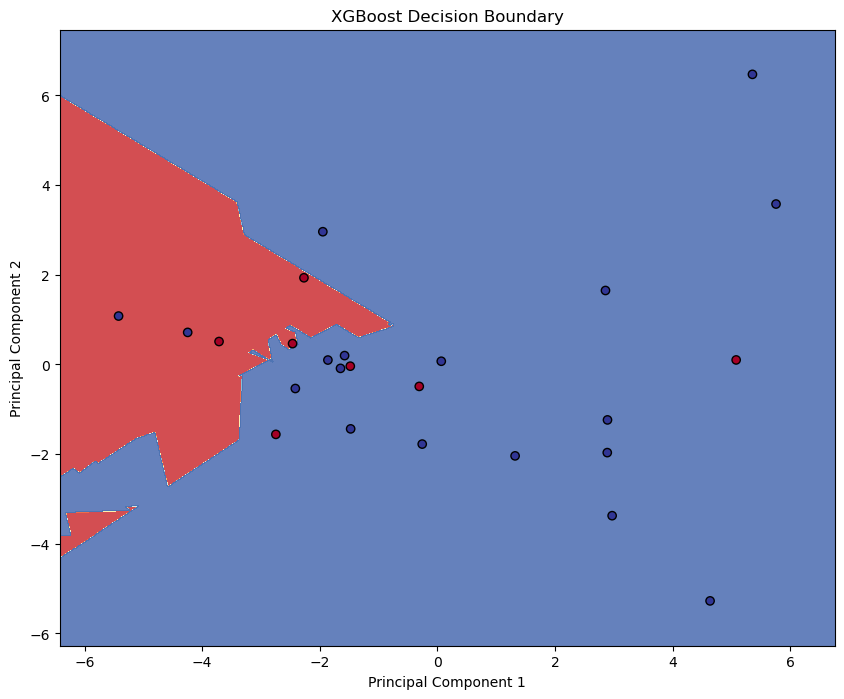

2025-01-10 10:01:32,980 - INFO - Decision boundary plot displayed successfully.
2025-01-10 10:01:32,987 - INFO - Generating feature importance plots for XGBoost...


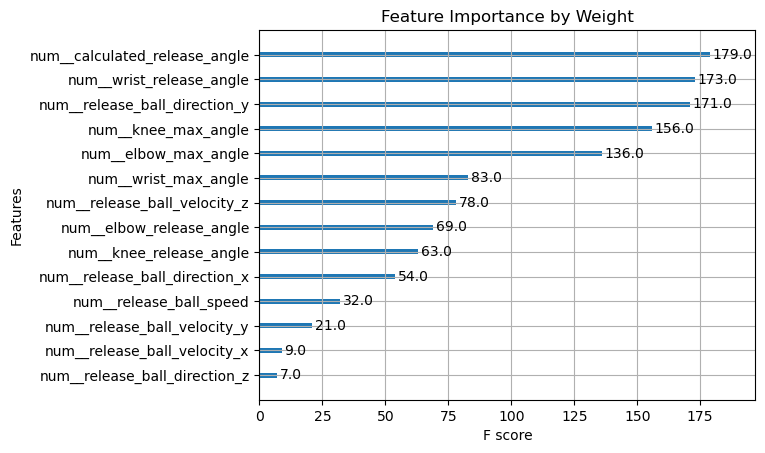

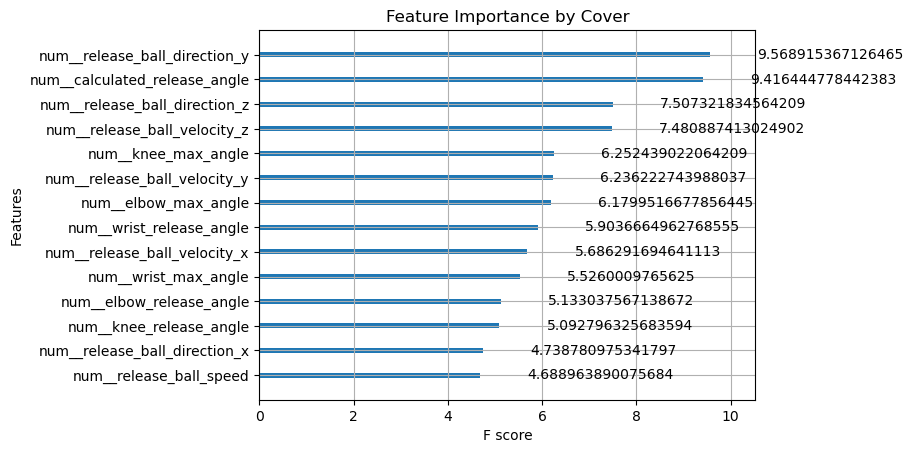

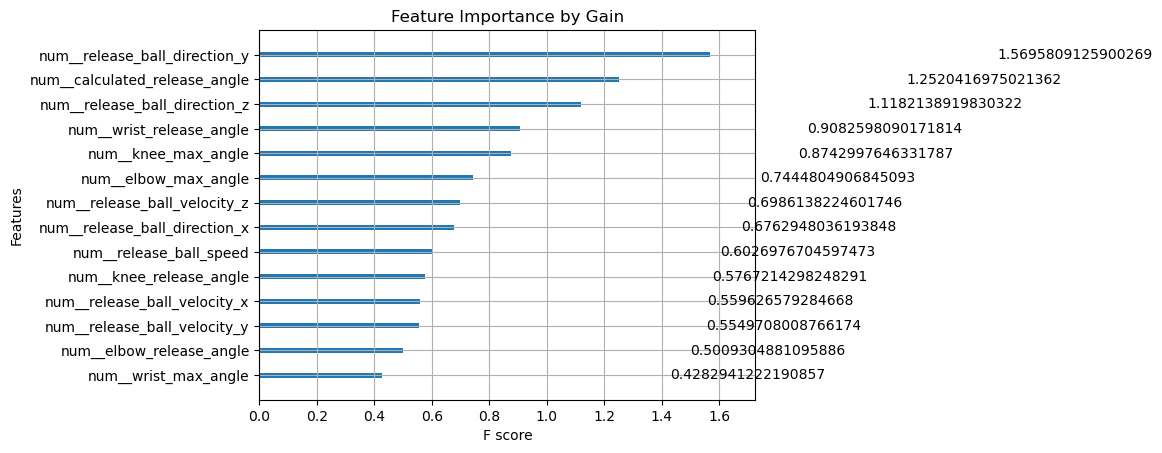

2025-01-10 10:01:33,362 - INFO - 📌 Tuning hyperparameters for Random Forest...
2025-01-10 10:01:33,362 - INFO - Starting hyperparameter tuning for Random Forest...
2025-01-10 10:01:33,366 - INFO - Parameter space: {'n_estimators': Integer(low=10, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None), 'bootstrap': Categorical(categories=(True, False), prior=None), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None)}
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [True, 'gini', 50, 'log2', 2, 2, 10] before, using random point [True, 'entrop

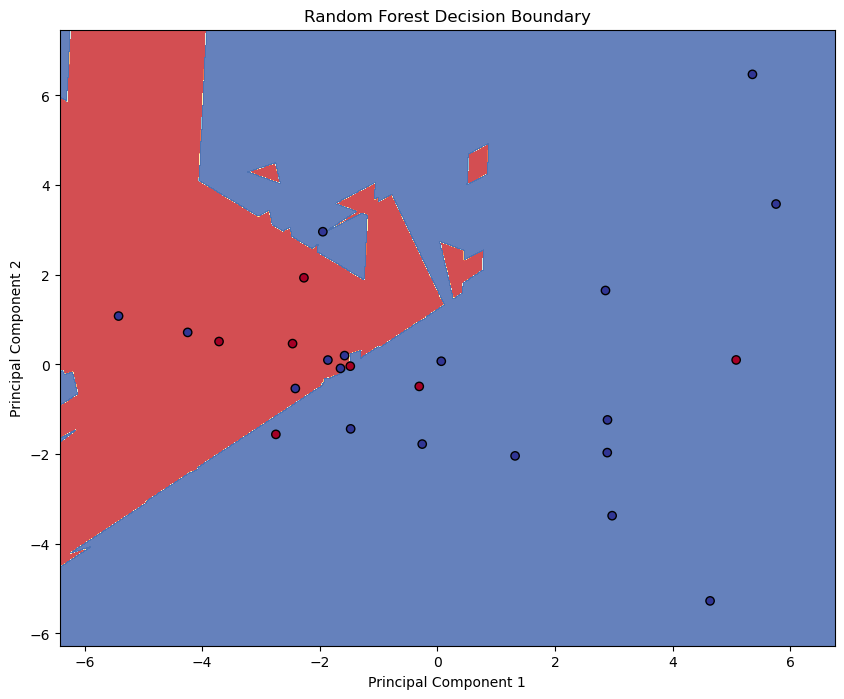

2025-01-10 10:02:40,315 - INFO - Decision boundary plot displayed successfully.
2025-01-10 10:02:40,322 - INFO - 📌 Tuning hyperparameters for Decision Tree...
2025-01-10 10:02:40,322 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-01-10 10:02:40,325 - INFO - Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 9, 2, 'random'] before, using random point ['entropy', 25, 10, 9, 'best']
  warnings.warn(
c:\Users\ghadf\anaconda3\envs\data_science_ft_bi

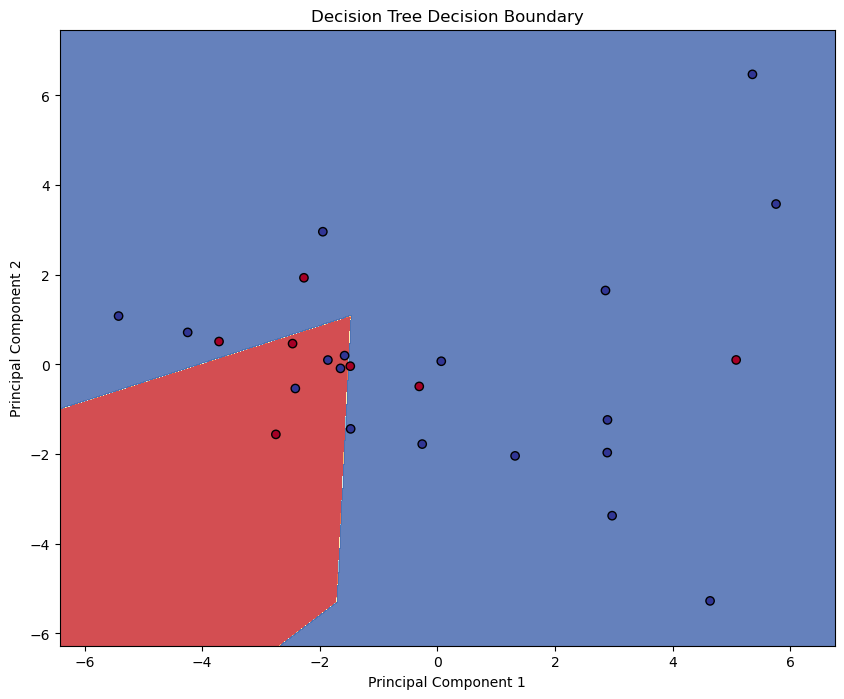

2025-01-10 10:03:23,223 - INFO - Decision boundary plot displayed successfully.
2025-01-10 10:03:23,230 - INFO - ✅ Best model is XGBoost with Log Loss=0.6266519843898917
2025-01-10 10:03:23,238 - INFO - Model saved to C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions\preprocessor\models\XGBoost_model.pkl
2025-01-10 10:03:23,238 - INFO - ✅ Model 'XGBoost' saved successfully in 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions\preprocessor\models'.
2025-01-10 10:03:23,240 - INFO - ✅ Tuning results saved to C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions\preprocessor\models\tuning_results.json.
2025-01-10 10:03:23,242 [INFO] ✅ Training workflow completed successfully.
2025-01-10 10:03:23,242 - INFO - ✅ Training workflow completed successfully.


In [ ]:
import logging
import json
from typing import Any, Dict
from pathlib import Path
import yaml
import pandas as pd
import joblib  # Ensure joblib is imported

# Local imports - Adjust the import paths based on your project structure
from datapreprocessor import DataPreprocessor
# from train.train_utils import (
#     evaluate_model, save_model, load_model, plot_decision_boundary,
#     tune_random_forest, tune_xgboost, tune_decision_tree
# )
# from model_factory import get_model

logger = logging.getLogger(__name__)

def load_config(config_path: Path) -> Dict[str, Any]:
    """
    Load configuration from a YAML file.

    Args:
        config_path (Path): Path to the configuration file.

    Returns:
        Dict[str, Any]: Configuration dictionary.
    """
    try:
        with config_path.open('r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    A streamlined function that:
      1) Tunes and trains models using Bayesian optimization.
      2) Evaluates the best model.
      3) Saves the tuning results and best model.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        selection_metric (str): Metric to select best model (e.g., "Log Loss", "accuracy").
        model_save_dir (Path): Directory to save the best model.
        classification_save_path (Path): Path to save classification report.
        tuning_results_save (Path): Path to save tuning results in JSON format.
        selected_models (list|str): List of models (e.g. ["XGBoost", "Random Forest"]) or a single string.
        use_pca (bool): If True, uses PCA for boundary plotting. Typically False for tree-based models.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = selection_metric.lower().replace(" ", "_")
            metric_value = metrics.get(metric_key)

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

            # Add feature importance plots for XGBoost
            if model_name.lower() == "xgboost":
                logger.info("Generating feature importance plots for XGBoost...")
                try:
                    xgb.plot_importance(best_model, importance_type="weight")
                    plt.title("Feature Importance by Weight")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="cover")
                    plt.title("Feature Importance by Cover")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="gain")
                    plt.title("Feature Importance by Gain")
                    plt.show()
                except Exception as e:
                    logger.error(f"Error generating feature importance plots: {e}")
        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")


def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config = load_config(Path('../../data/model/preprocessor_config/preprocessor_config.yaml'))

    # Extract paths from configuration
    paths_config = config.get('paths', {})
    base_data_dir = Path(paths_config.get('data_dir', '../../dataset/test/data')).resolve()
    raw_data_file = base_data_dir / paths_config.get('raw_data', 'final_ml_dataset.csv')

    # Output directories
    log_dir = Path(paths_config.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_base_dir = Path(paths_config.get('model_save_base_dir', '../preprocessor/models')).resolve()
    transformers_save_base_dir = Path(paths_config.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()
    plots_output_dir = Path(paths_config.get('plots_output_dir', '../preprocessor/plots')).resolve()
    training_output_dir = Path(paths_config.get('training_output_dir', '../preprocessor/training_output')).resolve()

    # Initialize Paths for saving
    MODEL_SAVE_DIR = model_save_base_dir
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    CLASSIFICATION_REPORT_PATH = MODEL_SAVE_DIR / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = MODEL_SAVE_DIR / "tuning_results.json"


    LOG_FILE = 'training.log'

    # Extract model-related config
    selected_models = config.get('models', {}).get('selected_models', ["XGBoost", "Random Forest", "Decision Tree"])
    selection_metric = config.get('models', {}).get('selection_metric', "Log Loss")

    # Extract Tree Based Classifier options from config
    tree_classifier_options = config.get('models', {}).get('Tree Based Classifier', {})

    # ----------------------------
    # 2. Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, LOG_FILE)
    logger.info("✅ Starting the training module.")

    # ----------------------------
    # 3. Load Data
    # ----------------------------
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except FileNotFoundError:
        logger.error(f"❌ Dataset not found at {raw_data_file}.")
        return
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return

    # Extract feature assets
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # 4. Initialize DataPreprocessor
    # ----------------------------
    # Assuming a supervised classification use case: "Tree Based Classifier"
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []), 
        mode='train',
        options=tree_classifier_options,  # The options from config for "Tree Based Classifier"
        debug=config.get('logging', {}).get('debug', False),  # or config-based
        normalize_debug=config.get('execution', {}).get('train', {}).get('normalize_debug', False),
        normalize_graphs_output=config.get('execution', {}).get('train', {}).get('normalize_graphs_output', False),
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_base_dir
    )

    # ----------------------------
    # 5. Execute Preprocessing
    # ----------------------------
    try:
        # Execute preprocessing by passing the entire filtered_df
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        print("types of all variables starting with X_train", type(X_train), "X_test type", type(X_test), "y_train type =", type(y_train), "y_test type =", type(y_test),"X_test_inverse type =", type(X_test_inverse))
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return
 
    # ----------------------------
    # 6. Train & Tune the Model
    # ----------------------------
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=MODEL_SAVE_DIR,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    # ----------------------------
    # 7. Completion Message
    # ----------------------------
    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()

In [11]:
# src/ml/predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
# from train_utils.train_utils import load_model  # Ensure correct import path
# from datapreprocessor.datapreprocessor import DataPreprocessor  # Uncomment and adjust as necessary

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'prediction.log') -> logging.Logger:
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename

    logger = logging.getLogger('model_prediction')
    logger.setLevel(logging.INFO)

    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create handlers
    f_handler = logging.FileHandler(log_path)
    f_handler.setLevel(logging.INFO)
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)

    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)

    return logger

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../data/processed')).resolve()
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_dir = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 4: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Or dynamically set based on best_model_name if necessary
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},  # Adjust based on config or load from somewhere
        debug=False,  # Can be parameterized
        normalize_debug=False,  # As per hardcoded paths
        normalize_graphs_output=False,  # As per hardcoded paths
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        logger.info(f"✅ Trained model loaded from '{model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions
    # ----------------------------
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    # ----------------------------
    # Step 9: Attach Predictions to Inversed Data
    # ----------------------------
    if X_inversed is not None:
        if len(predictions) == len(X_inversed):
            X_inversed['predictions'] = predictions
            logger.info("✅ Predictions attached to inversed data successfully.")
        else:
            logger.error("❌ Predictions length does not match inversed data length.")
            return
    else:
        logger.error("❌ Inversed data is None. Cannot attach predictions.")
        return

    # ----------------------------
    # Step 10: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")


if __name__ == "__main__":
    main()

2025-01-10 10:03:23,330 [INFO] ✅ Starting prediction module.
2025-01-10 10:03:23,330 - INFO - ✅ Starting prediction module.
2025-01-10 10:03:23,333 [INFO] Best model identified: XGBoost
2025-01-10 10:03:23,333 - INFO - Best model identified: XGBoost
2025-01-10 10:03:23,343 [INFO] ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\processed\final_ml_dataset.csv'.
2025-01-10 10:03:23,343 - INFO - ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\processed\final_ml_dataset.csv'.
2025-01-10 10:03:23,344 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-01-10 10:03:23,344 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-01-10 10:03:23,345 [INFO] Step: filter_columns
2025-01-10 10:03:23,345 - INFO - Step: filter_columns
2025-01-10 10:03:23,347 [INFO] ✅ Filtered DataFrame to i

X_new_preprocessed type =  <class 'pandas.core.frame.DataFrame'> X_new_inverse type =  <class 'pandas.core.frame.DataFrame'>


In [12]:
#%%writefile ../../src/freethrow_predictions/ml/shap/shap_utils.py

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


def setup_logging(debug: bool = False) -> logging.Logger:
    """
    Configure and return a logger.

    :param debug: If True, set logging level to DEBUG. Otherwise, INFO.
    :return: Configured logger.
    """
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(level=level, 
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    logger = logging.getLogger(__name__)
    return logger



def compute_shap_values(model, X, debug: bool = False, logger: logging.Logger = None):
    if logger:
        logger.info("Initializing SHAP explainer...")

    try:
        explainer = shap.Explainer(model, X)
        if logger and debug:
            logger.debug(f"SHAP Explainer initialized: {type(explainer)}")
            logger.debug(f"Explainer details: {explainer}")

        shap_values = explainer(X)
        if logger and debug:
            logger.debug(f"SHAP values computed: {type(shap_values)}")
            logger.debug(f"Shape of shap_values: {shap_values.shape}")
            if hasattr(shap_values, 'values'):
                logger.debug(f"Sample SHAP values:\n{shap_values.values[:2]}")
            if hasattr(shap_values, 'feature_names'):
                logger.debug(f"SHAP feature names: {shap_values.feature_names}")

        # Determine number of classes
        n_classes = len(model.classes_)
        logger.debug(f"Number of classes in the model: {n_classes}")

        if shap_values.values.ndim == 3:
            if n_classes > 1:
                # For multi-class classification, select SHAP values for the positive class
                shap_values_class = shap_values.values[:, :, 1]
                logger.debug(f"Extracted SHAP values for class 1: Shape {shap_values_class.shape}")
            else:
                # For single-class models, retain SHAP values as is
                shap_values_class = shap_values.values[:, :, 0]
                logger.debug(f"Extracted SHAP values for single class: Shape {shap_values_class.shape}")
        elif shap_values.values.ndim == 2:
            if n_classes > 1:
                # For binary classification, SHAP returns 2D array for the positive class
                shap_values_class = shap_values.values
                logger.debug(f"Extracted SHAP values for positive class: Shape {shap_values_class.shape}")
            else:
                shap_values_class = shap_values.values
                logger.debug(f"Extracted SHAP values for single class: Shape {shap_values_class.shape}")
        else:
            logger.error(f"Unexpected SHAP values dimensions: {shap_values.values.ndim}")
            raise ValueError("Unexpected SHAP values dimensions.")

        return explainer, shap_values_class
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values: {e}")
        raise


def plot_shap_summary(shap_values, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                     logger: logging.Logger = None):
    """
    Generate and save a SHAP summary plot.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (preprocessed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info("Generating SHAP summary plot...")
        logger.debug(f"Type of shap_values: {type(shap_values)}")
        logger.debug(f"Shape of shap_values: {shap_values.shape}")
        
        # Check if shap_values is a shap.Explanation object
        if isinstance(shap_values, shap.Explanation):
            logger.debug(f"SHAP feature names: {shap_values.feature_names}")
        else:
            logger.debug("shap_values is not a shap.Explanation object. Attempting to extract feature names.")
            if hasattr(shap_values, 'feature_names'):
                logger.debug(f"shap_values feature names: {shap_values.feature_names}")
            else:
                logger.debug("Cannot extract feature names from shap_values.")
        
        logger.debug(f"Type of X_original: {type(X_original)}")
        logger.debug(f"Shape of X_original: {X_original.shape}")
        logger.debug(f"Columns in X_original: {X_original.columns.tolist()}")
        
        # Verify column alignment
        if isinstance(shap_values, shap.Explanation):
            shap_feature_names = shap_values.feature_names
        elif hasattr(shap_values, 'feature_names'):
            shap_feature_names = shap_values.feature_names
        else:
            shap_feature_names = X_original.columns.tolist()  # Fallback
        
        if list(shap_feature_names) != list(X_original.columns):
            logger.error("Column mismatch between SHAP values and X_original.")
            logger.error(f"SHAP feature names ({len(shap_feature_names)}): {shap_feature_names}")
            logger.error(f"X_original columns ({len(X_original.columns)}): {X_original.columns.tolist()}")
            raise ValueError("Column mismatch between SHAP values and X_original.")
        else:
            logger.debug("Column alignment verified between SHAP values and X_original.")
    
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP summary plot saved to {save_path}")
        if logger:
            logger.info("SHAP summary plot generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP summary plot: {e}")
        raise




def plot_shap_dependence(shap_values, feature: str, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                         logger: logging.Logger = None):
    """
    Generate and save a SHAP dependence plot for a specific feature.

    :param shap_values: SHAP values computed for the dataset.
    :param feature: Feature name to generate the dependence plot for.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info(f"Generating SHAP dependence plot for feature '{feature}'...")
    try:
        plt.figure(figsize=(8, 6))
        # shap.dependence_plot(feature, shap_values.values, X_original, show=False)
        shap.dependence_plot(feature, shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP dependence plot for '{feature}' saved to {save_path}")
        if logger:
            logger.info(f"SHAP dependence plot for feature '{feature}' generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP dependence plot for feature '{feature}': {e}")
        raise


def generate_global_recommendations(shap_values, X_original: pd.DataFrame, top_n: int = 5, debug: bool = False, 
                                    use_mad: bool = False, logger: logging.Logger = None) -> dict:
    """
    Generate global recommendations based on SHAP values and feature distributions.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param top_n: Number of top features to generate recommendations for.
    :param debug: If True, enable detailed debug logs.
    :param use_mad: If True, use Median Absolute Deviation for range definition.
    :param logger: Logger instance for logging.
    :return: recommendations: Dictionary mapping features to recommended value ranges, importance, and direction.
    """
    if logger:
        logger.info("Generating feature importance based on SHAP values...")
    try:
        # shap_df = pd.DataFrame(shap_values.values, columns=X_original.columns)
        shap_df = pd.DataFrame(shap_values, columns=X_original.columns)

        # Calculate mean absolute SHAP values for importance
        feature_importance = pd.DataFrame({
            'feature': X_original.columns,
            'importance': np.abs(shap_df).mean(axis=0),
            'mean_shap': shap_df.mean(axis=0)
        }).sort_values(by='importance', ascending=False)
        
        if logger and debug:
            logger.debug(f"Feature importance (top {top_n}):\n{feature_importance.head(top_n)}")
        
        top_features = feature_importance.head(top_n)['feature'].tolist()
        recommendations = {}
        
        for feature in top_features:
            feature_values = X_original[feature]
            
            if use_mad:
                # Use Median and MAD for robust statistics
                median = feature_values.median()
                mad = feature_values.mad()
                lower_bound = median - 1.5 * mad
                upper_bound = median + 1.5 * mad
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            else:
                # Default to Interquartile Range (IQR)
                lower_bound = feature_values.quantile(0.25)
                upper_bound = feature_values.quantile(0.75)
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            
            # Determine direction based on mean SHAP value
            mean_shap = feature_importance.loc[feature_importance['feature'] == feature, 'mean_shap'].values[0]
            direction = 'positive' if mean_shap > 0 else 'negative'
            
            recommendations[feature] = {
                'range': range_str,
                'importance': round(feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0], 4),  # Rounded for readability
                'direction': direction
            }
            if logger and debug:
                logger.debug(f"Recommendation for {feature}: Range={range_str}, Importance={feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0]}, Direction={direction}")
        
        if logger and debug:
            logger.debug(f"Final Recommendations with Importance and Direction: {recommendations}")
        return recommendations
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate global recommendations: {e}")
        raise


def generate_individual_feedback(trial: pd.Series, shap_values_trial: np.ndarray, feature_metadata: dict = None, 
                                 logger: logging.Logger = None) -> dict:
    """
    Generate specific feedback for a single trial based on its SHAP values and feature metadata.

    Args:
        trial (pd.Series): A single trial's data.
        shap_values_trial (np.ndarray): SHAP values for the trial.
        feature_metadata (dict, optional): Additional metadata for features (e.g., units).
        logger (logging.Logger, optional): Logger instance for logging.

    Returns:
        dict: Feedback messages for each feature.
    """
    feedback = {}
    feature_names = trial.index.tolist()

    for feature, shap_value in zip(feature_names, shap_values_trial):
        if shap_value > 0:
            adjustment = "maintain or increase"
            direction = "positively"
        elif shap_value < 0:
            adjustment = "decrease"
            direction = "positively"
        else:
            feedback[feature] = f"{feature.replace('_', ' ').capitalize()} has no impact on the prediction."
            continue

        # Map SHAP values to meaningful adjustment magnitudes
        # Example: 10% of the current feature value
        current_value = trial[feature]
        adjustment_factor = 0.1
        adjustment_amount = adjustment_factor * abs(current_value)

        # Incorporate feature metadata if available
        if feature_metadata and feature in feature_metadata:
            unit = feature_metadata[feature].get('unit', '')
            adjustment_str = f"{adjustment_amount:.2f} {unit}" if unit else f"{adjustment_amount:.2f}"
        else:
            adjustment_str = f"{adjustment_amount:.2f}"

        # Construct feedback message
        feedback_message = (
            f"Consider to {adjustment} '{feature.replace('_', ' ')}' by approximately {adjustment_str} "
            f"to {direction} influence the result."
        )
        feedback[feature] = feedback_message

    return feedback


def compute_individual_shap_values(explainer, X_transformed: pd.DataFrame, trial_index: int, 
                                   logger: logging.Logger = None):
    """
    Compute SHAP values for a single trial.

    :param explainer: SHAP explainer object.
    :param X_transformed: Transformed features used for prediction.
    :param trial_index: Index of the trial.
    :param logger: Logger instance.
    :return: shap_values for the trial.
    """
    if logger:
        logger.info(f"Computing SHAP values for trial at index {trial_index}...")
    try:
        trial = X_transformed.iloc[[trial_index]]
        shap_values = explainer(trial)
        if logger:
            logger.debug(f"SHAP values for trial {trial_index} computed successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values for trial {trial_index}: {e}")
        raise
    return shap_values


def plot_individual_shap_force(shap_explainer, shap_values, X_original: pd.DataFrame, trial_index: int, 
                               save_path: str, logger: logging.Logger = None):
    """
    Generate and save a SHAP force plot for a specific trial.

    :param shap_explainer: SHAP explainer object.
    :param shap_values: SHAP values for the trial.
    :param X_original: Original feature DataFrame.
    :param trial_index: Index of the trial.
    :param save_path: Full file path to save the force plot.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Generating SHAP force plot for trial {trial_index}...")
    try:
        shap_plot = shap.force_plot(
            shap_explainer.expected_value, 
            shap_values.values[0], 
            X_original.iloc[trial_index],
            matplotlib=False
        )
        shap.save_html(save_path, shap_plot)
        if logger:
            logger.debug(f"SHAP force plot saved to {save_path}")
            logger.info(f"SHAP force plot for trial {trial_index} generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP force plot for trial {trial_index}: {e}")
        raise


def extract_force_plot_values(shap_values, trial_index: int, logger: logging.Logger = None) -> dict:
    """
    Extract SHAP values and feature contributions for a specific trial.

    Args:
        shap_values (shap.Explanation): SHAP values object.
        trial_index (int): Index of the trial.
        logger (logging.Logger, optional): Logger instance.

    Returns:
        dict: Dictionary of feature contributions.
    """
    try:
        shap_values_instance = shap_values.values[trial_index]
        features_instance = shap_values.data[trial_index]
        feature_contributions = dict(zip(shap_values.feature_names, shap_values_instance))
        if logger and logger.isEnabledFor(logging.DEBUG):
            logger.debug(f"SHAP values for trial {trial_index}: {feature_contributions}")
        return feature_contributions
    except Exception as e:
        if logger:
            logger.error(f"Error extracting SHAP values for trial {trial_index}: {e}")
        raise


def save_shap_values(shap_values, save_path: str, logger: logging.Logger = None):
    """
    Save SHAP values to a file using pickle.

    :param shap_values: SHAP values object to save.
    :param save_path: File path to save the SHAP values.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Saving SHAP values to {save_path}...")
    try:
        with open(save_path, "wb") as f:
            pickle.dump(shap_values, f)
        if logger:
            logger.info(f"SHAP values saved successfully to {save_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to save SHAP values: {e}")
        raise


def load_shap_values(load_path: str, logger: logging.Logger = None):
    """
    Load SHAP values from a pickle file.

    :param load_path: File path to load the SHAP values from.
    :param logger: Logger instance.
    :return: Loaded SHAP values object.
    """
    if logger:
        logger.info(f"Loading SHAP values from {load_path}...")
    try:
        with open(load_path, "rb") as f:
            shap_values = pickle.load(f)
        if logger:
            logger.info(f"SHAP values loaded successfully from {load_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load SHAP values: {e}")
        raise
    return shap_values


In [13]:
# src/ml/predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict
from datapreprocessor import DataPreprocessor
# Local imports - Uncomment and adjust based on your project structure
# from shap_utils import (
#     setup_logging,
#     compute_shap_values,
#     plot_shap_summary,
#     plot_shap_dependence,
#     generate_global_recommendations,
#     generate_individual_feedback
# )
# from train import load_model  # Ensure 'train.py' is correctly implemented


def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)


def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config


def setup_logging_custom(log_dir: Path, log_filename: str = 'prediction.log') -> logging.Logger:
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename

    logger = logging.getLogger('model_prediction')
    logger.setLevel(logging.DEBUG)  # Set to DEBUG to capture all debug logs

    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create handlers
    f_handler = logging.FileHandler(log_path)
    f_handler.setLevel(logging.DEBUG)  # Capture all logs in file
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)  # Only INFO and above on console

    # Create formatters and add them to handlers
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)

    return logger


def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
        print(f"Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../data/processed')).resolve()
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_path = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger = setup_logging_custom(log_dir, log_file)
    logger.info("✅ Starting prediction module.")
    logger.debug(f"Configuration paths extracted: {paths}")

    # ----------------------------
    # Step 4: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }
    logger.debug(f"Column assets extracted: {column_assets}")

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
        logger.debug(f"Best model details: {best_model_info}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
        logger.debug(f"Prediction input data shape: {df_predict.shape}")
        logger.debug(f"Prediction input data columns: {df_predict.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Or dynamically set based on best_model_name if necessary
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},  # Adjust based on config or load from somewhere
        debug=True,  # Enable debug mode for detailed logs
        normalize_debug=False,  # As per hardcoded paths
        normalize_graphs_output=False,  # As per hardcoded paths
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
        logger.debug(f"Shape of X_preprocessed: {X_preprocessed.shape}")
        logger.debug(f"Columns in X_preprocessed: {X_preprocessed.columns.tolist()}")
        logger.debug(f"Shape of X_inversed: {X_inversed.shape}")
        logger.debug(f"Columns in X_inversed: {X_inversed.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        model_path = model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'
        logger.info(f"✅ Trained model loaded from '{model_path}'.")
        logger.debug(f"Trained model type: {type(trained_model)}")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions
    # ----------------------------
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
        logger.debug(f"Predictions sample: {predictions[:5]}")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    # ----------------------------
    # Step 8.1: Make Prediction Probabilities
    # ----------------------------
    try:
        prediction_probs = trained_model.predict_proba(X_preprocessed)
        logger.info("✅ Prediction probabilities computed successfully.")
        logger.debug(f"Prediction probabilities sample:\n{prediction_probs[:2]}")
    except Exception as e:
        logger.error(f"❌ Prediction probabilities computation failed: {e}")
        return

    # ----------------------------
    # Step 12: Compute SHAP Values for Interpretability
    # ----------------------------
    try:
        logger.info("📊 Computing SHAP values for interpretability...")
        explainer, shap_values = compute_shap_values(
            trained_model, 
            X_preprocessed,  # Compute SHAP on preprocessed data
            debug=config.get('logging', {}).get('debug', False), 
            logger=logger
        )
        logger.info("✅ SHAP values computed successfully.")
        
        # Additional Debugging
        logger.debug(f"Type of shap_values: {type(shap_values)}")
        logger.debug(f"Shape of shap_values: {shap_values.shape}")
        if hasattr(shap_values, 'feature_names'):
            logger.debug(f"SHAP feature names: {shap_values.feature_names}")
        else:
            logger.debug("shap_values does not have 'feature_names' attribute.")
        
        logger.debug(f"Type of X_preprocessed: {type(X_preprocessed)}")
        logger.debug(f"Shape of X_preprocessed: {X_preprocessed.shape}")
        logger.debug(f"Columns in X_preprocessed: {X_preprocessed.columns.tolist()}")
        
        # Check feature alignment
        if hasattr(shap_values, 'feature_names'):
            shap_feature_names = shap_values.feature_names
        else:
            shap_feature_names = X_preprocessed.columns.tolist()
        
        if list(shap_feature_names) != list(X_preprocessed.columns):
            logger.error("Column mismatch between SHAP values and X_preprocessed.")
            logger.error(f"SHAP feature names ({len(shap_feature_names)}): {shap_feature_names}")
            logger.error(f"X_preprocessed columns ({len(X_preprocessed.columns)}): {X_preprocessed.columns.tolist()}")
            raise ValueError("Column mismatch between SHAP values and X_preprocessed.")
        else:
            logger.debug("Column alignment verified between SHAP values and X_preprocessed.")
        
        # Ensure all features are numeric
        X_preprocessed = X_preprocessed.apply(pd.to_numeric, errors='coerce')
        logger.debug("Converted all features in X_preprocessed to numeric types.")
        
        # Check for non-numeric columns
        non_numeric_cols = X_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_cols:
            logger.error(f"Non-numeric columns found in X_preprocessed: {non_numeric_cols}")
            raise ValueError("All features must be numeric for SHAP plotting.")
        else:
            logger.debug("All features in X_preprocessed are numeric.")
        
        # Check for missing values in shap_values
        if hasattr(shap_values, 'values'):
            if pd.isnull(shap_values.values).any():
                logger.warning("SHAP values contain NaNs.")
            else:
                logger.debug("SHAP values do not contain NaNs.")
        else:
            logger.warning("shap_values do not have 'values' attribute.")
        
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values: {e}")
        return

    # ----------------------------
    # Step 13: Generate SHAP Summary Plot
    # ----------------------------
    try:
        shap_summary_path = os.path.join(predictions_output_path, 'shap_summary.png')
        logger.debug(f"SHAP summary plot will be saved to: {shap_summary_path}")
        
        # Pass X_preprocessed to SHAP plotting functions
        plot_shap_summary(
            shap_values=shap_values, 
            X_original=X_preprocessed,  # Use preprocessed data that matches SHAP values
            save_path=shap_summary_path, 
            debug=config.get('logging', {}).get('debug', False), 
            logger=logger
        )
        logger.info(f"✅ SHAP summary plot saved to '{shap_summary_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP summary plot: {e}")
        return

    # ----------------------------
    # Step 14: Generate SHAP Dependence Plots for Top Features
    # ----------------------------
    try:
        top_n = len(X_inversed.columns)   # Define how many top features you want
        logger.debug(f"Generating SHAP dependence plots for top {top_n} features.")
        recommendations = generate_global_recommendations(
            shap_values=shap_values, 
            X_original=X_preprocessed,  # Use preprocessed data
            top_n=top_n, 
            debug=config.get('logging', {}).get('debug', False), 
            use_mad=False,  # Set to True if using MAD for range definitions
            logger=logger
        )
        shap_dependence_dir = os.path.join(predictions_output_path, 'shap_dependence_plots')
        os.makedirs(shap_dependence_dir, exist_ok=True)
        logger.debug(f"SHAP dependence plots will be saved to: {shap_dependence_dir}")
        for feature in recommendations.keys():
            shap_dependence_filename = f"shap_dependence_{feature}.png"
            shap_dependence_path = os.path.join(shap_dependence_dir, shap_dependence_filename)
            logger.debug(f"Generating SHAP dependence plot for feature '{feature}' at '{shap_dependence_path}'.")
            plot_shap_dependence(
                shap_values=shap_values, 
                feature=feature, 
                X_original=X_preprocessed,  # Use preprocessed data
                save_path=shap_dependence_path, 
                debug=config.get('logging', {}).get('debug', False), 
                logger=logger
            )
        logger.info(f"✅ SHAP dependence plots saved to '{shap_dependence_dir}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP dependence plots: {e}")
        return

    # ----------------------------
    # Step 11: Attach Predictions to Inverse-Transformed DataFrame
    # ----------------------------
    try:
        if X_inversed is not None:
            if 'Prediction' not in X_inversed.columns:
                X_inversed['Prediction'] = predictions
                logger.debug("Predictions attached to inverse-transformed DataFrame.")
            if 'Prediction_Probabilities' not in X_inversed.columns:
                X_inversed['Prediction_Probabilities'] = prediction_probs.tolist()
                logger.debug("Prediction probabilities attached to inverse-transformed DataFrame.")
            logger.debug(f"Final shape of X_inversed: {X_inversed.shape}")
            logger.debug(f"Final columns in X_inversed: {X_inversed.columns.tolist()}")
        else:
            logger.warning("X_inversed is None. Creating a new DataFrame with predictions.")
            X_inversed = pd.DataFrame({'Prediction': predictions, 'Prediction_Probabilities': prediction_probs.tolist()})
            logger.debug(f"Created new X_inversed DataFrame with shape: {X_inversed.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to attach predictions to inverse-transformed DataFrame: {e}")
        X_inversed = pd.DataFrame({'Prediction': predictions})  # Assign to X_inversed

    # ----------------------------
    # Step 15: Annotate Final Dataset with SHAP Recommendations
    # ----------------------------
    try:
        logger.info("🔍 Annotating final dataset with SHAP recommendations...")
        logger.debug(f"Features in recommendations: {list(recommendations.keys())}")
        logger.debug(f"Features in X_inversed: {X_inversed.columns.tolist()}")
        for feature, rec in recommendations.items():
            feature_mapping = {feature: feature.replace('num__', '') for feature in recommendations.keys()}
            # Remove 'num__' prefix
            original_feature = feature.replace('num__', '')
            
            # Check if the original feature exists in X_inversed
            if original_feature not in X_inversed.columns:
                logger.error(f"Feature '{original_feature}' not found in X_inversed. Skipping annotation.")
                continue
            
            range_str = rec.get('range', '')
            importance = rec.get('importance', None)
            direction = rec.get('direction', 'positive')
            X_inversed[f"{original_feature}_shap_recommendation"] = range_str
            X_inversed[f"{original_feature}_shap_importance"] = importance
            X_inversed[f"{original_feature}_shap_direction"] = direction

            # Clean the range string and parse min and max
            clean_range_str = range_str.replace('°', '')
            try:
                min_val_str, max_val_str = clean_range_str.split('–')
                min_val = float(min_val_str)
                max_val = float(max_val_str)
            except ValueError as ve:
                logger.error(f"Invalid range format for feature '{original_feature}': {range_str}. Error: {ve}")
                X_inversed[f"{original_feature}_shap_status"] = "Invalid Range Format"
                continue

            # Apply status based on the range
            X_inversed[f"{original_feature}_shap_status"] = X_inversed[original_feature].apply(
                lambda x: "Within Range" if min_val <= x <= max_val else (
                    "Below Range" if x < min_val else "Above Range"
                )
            )
            logger.debug(f"Annotated feature '{original_feature}' with SHAP recommendations.")

    except Exception as e:
        logger.error(f"❌ Failed to annotate final dataset with SHAP recommendations: {e}")
        return

    # ----------------------------
    # Step 16: Generate Specific Feedback for Each Trial
    # ----------------------------
    try:
        logger.info("📝 Generating specific feedback for each trial based on SHAP values...")
        feature_metadata = {}
        for feature in X_preprocessed.columns:
            if 'angle' in feature.lower():
                unit = 'degrees'
            else:
                unit = 'meters'
            feature_metadata[feature] = {'unit': unit}

        specific_feedback_list = []
        for idx in X_inversed.index:
            trial = X_inversed.loc[idx]
            shap_values_trial = shap_values[idx]  # Removed .values
            feedback = generate_individual_feedback(trial, shap_values_trial, feature_metadata, logger=logger)
            specific_feedback_list.append(feedback)
            if config.get('logging', {}).get('debug', False):
                logger.debug(f"Generated feedback for trial {idx}: {feedback}")
        X_inversed['specific_feedback'] = specific_feedback_list

        logger.info("✅ Specific feedback generated for all trials.")
    except Exception as e:
        logger.error(f"❌ Failed to generate specific feedback: {e}")
        return

    # ----------------------------
    # Step 17: Save the Final Dataset with Predictions and SHAP Annotations
    # ----------------------------
    try:
        os.makedirs(predictions_output_path, exist_ok=True)
        final_output_path = os.path.join(predictions_output_path, 'final_predictions_with_shap.csv')
        X_inversed.to_csv(final_output_path, index=False)
        logger.info(f"✅ Final dataset with predictions and SHAP annotations saved to '{final_output_path}'.")
        logger.debug(f"Final dataset shape: {X_inversed.shape}")
        logger.debug(f"Final dataset columns: {X_inversed.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Failed to save the final dataset: {e}")
        return

    # ----------------------------
    # Step 18: Save Global Recommendations as JSON
    # ----------------------------
    try:
        recommendations_filename = "global_shap_recommendations.json"
        recommendations_save_path = os.path.join(predictions_output_path, recommendations_filename)
        with open(recommendations_save_path, "w") as f:
            json.dump(recommendations, f, indent=4)
        logger.info(f"✅ Global SHAP recommendations saved to '{recommendations_save_path}'.")
        logger.debug(f"Global SHAP recommendations saved.")
    except Exception as e:
        logger.error(f"❌ Failed to save global SHAP recommendations: {e}")
        return

    # ----------------------------
    # Step 19: Display Minimal Outputs
    # ----------------------------
    try:
        # Display the first few rows of the final dataset
        print("\nInverse Transformed Prediction DataFrame with Predictions and SHAP Annotations:")
        print(X_inversed.head())

        # Display global recommendations
        print("\nGlobal SHAP Recommendations:")
        for feature, rec in recommendations.items():
            print(f"{feature}: Range={rec['range']}, Importance={rec['importance']}, Direction={rec['direction']}")

        # Display specific feedback for each trial
        print("\nSpecific Feedback for Each Trial:")
        for idx, row in X_inversed.iterrows():
            print(f"Trial {idx + 1}:")
            for feature, feedback in row['specific_feedback'].items():
                print(f"  - {feedback}")
            print()
    except Exception as e:
        logger.error(f"❌ Error during displaying outputs: {e}")
        return

    logger.info("✅ Prediction pipeline with SHAP analysis completed successfully.")


if __name__ == "__main__":
    main()


2025-01-10 10:03:23,601 [INFO] ✅ Starting prediction module.
2025-01-10 10:03:23,601 - INFO - ✅ Starting prediction module.
2025-01-10 10:03:23,602 - DEBUG - Configuration paths extracted: {'data_dir': '../../data/processed', 'raw_data': 'final_ml_dataset.csv', 'processed_data_dir': 'preprocessor/processed', 'features_metadata_file': 'features_info/features_metadata.pkl', 'predictions_output_dir': 'preprocessor/predictions', 'config_file': '../../data/model/preprocessor_config/preprocessor_config.yaml', 'log_dir': 'preprocessor/logs', 'model_save_base_dir': 'preprocessor/models', 'transformers_save_base_dir': 'preprocessor/transformers', 'plots_output_dir': 'preprocessor/plots', 'training_output_dir': 'preprocessor/training_output'}
2025-01-10 10:03:23,602 - DEBUG - Column assets extracted: {'y_variable': ['result'], 'ordinal_categoricals': [], 'nominal_categoricals': [], 'numericals': ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_a

Configuration loaded successfully from ..\..\data\model\preprocessor_config\preprocessor_config.yaml.
X_new_preprocessed type =  <class 'pandas.core.frame.DataFrame'> X_new_inverse type =  <class 'pandas.core.frame.DataFrame'>


2025-01-10 10:03:24,057 - DEBUG - Number of classes in the model: 2
2025-01-10 10:03:24,059 - DEBUG - Extracted SHAP values for positive class: Shape (125, 14)
2025-01-10 10:03:24,059 [INFO] ✅ SHAP values computed successfully.
2025-01-10 10:03:24,059 - INFO - ✅ SHAP values computed successfully.
2025-01-10 10:03:24,062 - DEBUG - Type of shap_values: <class 'numpy.ndarray'>
2025-01-10 10:03:24,063 - DEBUG - Shape of shap_values: (125, 14)
2025-01-10 10:03:24,063 - DEBUG - shap_values does not have 'feature_names' attribute.
2025-01-10 10:03:24,064 - DEBUG - Type of X_preprocessed: <class 'pandas.core.frame.DataFrame'>
2025-01-10 10:03:24,065 - DEBUG - Shape of X_preprocessed: (125, 14)
2025-01-10 10:03:24,066 - DEBUG - Columns in X_preprocessed: ['num__release_ball_direction_x', 'num__release_ball_direction_z', 'num__release_ball_direction_y', 'num__elbow_release_angle', 'num__elbow_max_angle', 'num__wrist_release_angle', 'num__wrist_max_angle', 'num__knee_release_angle', 'num__knee_ma


Inverse Transformed Prediction DataFrame with Predictions and SHAP Annotations:
   release_ball_direction_x  release_ball_direction_z  \
0                  0.377012                  0.926203   
1                  0.417644                  0.901906   
2                  0.383086                  0.922353   
3                  0.292054                  0.956396   
4                  0.389917                  0.918894   

   release_ball_direction_y  elbow_release_angle  elbow_max_angle  \
0                  0.002969            72.325830       106.272118   
1                 -0.110176            58.430068       101.798798   
2                 -0.050096            73.883728       106.989633   
3                  0.003209            71.424835       104.160865   
4                 -0.059987            73.619348       103.832024   

   wrist_release_angle  wrist_max_angle  knee_release_angle  knee_max_angle  \
0            28.102765        35.918406           32.646276       63.541007   
1  

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>